# Showcase of explanations for cloud segmentation

This notebook presents the methods from the `meteors` package that can be used for explaining the remote sensing models implementing the segmentation problem. The objective of a model, implementing such task, is to divide the input image into similar spatial regions.  In this case, we will focus on *cloud segmentation* for multispectral imagery - the explained model will simply divide the input image into clouds or terrain.

The selected model for performing the cloud segmentation is *UNetMobV2_V1*, which is work based on the paper *`CloudSEN12`, a global dataset for semantic understanding of cloud and cloud shadow in `Sentinel-2`* Aybar et. al.

**Note:** Before running this notebook, make sure to install all the required libraries used in the notebook. It should be sufficient to install the newest version of the package `meteors` from PyPI, as it carry all the required dependencies. In some cases, however, a specific setup on your machine might require installing some additional ones. The `cloudsen12_models` module contains all the code needed for additional preprocessing and model loading. This directory can be downloaded directly from the [Vignettes in the `meteors` repository](https://github.com/xai4space/meteors/tree/main/examples/segmentation).


## Table of Contents
- [1. Loading the Model](#1-loading-the-model)
- [2. Loading the sample images](#loading-the-images)
- [4. Analyze HSI data with LIME](#4-analyze-hsi-data-with-lime)
  - [4.1. Spatial Analysis](#41-spatial-analysis)
  - [4.2. Spectral Analysis](#42-spectral-analysis)
- [5. Analyze the HSI data with attribution methods]()

## Loading the model

The module `cloudsen12_models` contains code sourced from github repository [Fersoil/cloudsen12_models](https://github.com/Fersoil/cloudsen12_models/), where you can find a modification of the original *UNetMobV2_V1* model implementation, which was slighlty adjusted for the PyTorch inputs and outputs and have reduced dependencies.

In [28]:
from cloudsen12_models import cloudsen12
import numpy as np
import matplotlib.pyplot as plt
import meteors as mt
import torch

import meteors.visualize as vis

In [29]:
model = cloudsen12.load_model_by_name(name="UNetMobV2_V1", weights_folder="cloudsen12_models")

cloudsen12_segment_interpretation = ["clear", "Thick cloud", "Thin cloud", "Cloud shadow"]

c:\Users\tymot\Documents\praca\pineapple\meteors2\examples\segmentation\cloudsen12_models\cloudsen12.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.lo

In [30]:
cloudsen12.MODELS_CLOUDSEN12.keys()

dict_keys(['cloudsen12', 'UNetMobV2_V1', 'UNetMobV2_V2', 'cloudsen12l2a', 'dtacs4bands', 'landsat30'])

## Loading the images

To faciliate the analysis and allow for better reproduction of the examples, the images used in this notebook are already preprocessed and ready to be segmented. The original image is sourced from the Google Earth Engine, from a *COPERNICUS/S2_HARMONIZED* collection and a *S2A_MSIL1C_20240417T064631_N0510_R020_T40RCN_20240417T091941* tile. 

The image was later preprocessed according to the code from [this notebook](https://github.com/IPL-UV/cloudsen12_models/blob/main/notebooks/run_in_gee_image.ipynb).

In [31]:
img = np.load("data/0.npz")["img"]

sentinel_central_wavelengths = [
    442.7,
    492.4,
    559.8,
    664.6,
    704.1,
    740.5,
    782.8,
    832.8,
    864.7,
    945.1,
    1373.5,
    1613.7,
    2202.4,
]

Now, to better visualize the image and give it additional context (the wavelengths), we will load it as an `HyperSpectral Image` object. The `HSI` dataclass automatically selects correct bands and provides the clean RGB plot from the multispectral image.

In [32]:
hsi = mt.HSI(image=img, wavelengths=sentinel_central_wavelengths)

In [33]:
cloudmask = model.predict(
    hsi.image.unsqueeze(0)
)  # prediction of the cloud mask with soft labels probablility of each class
cloudmask_hard_labels = torch.argmax(cloudmask, dim=1).type(torch.uint8)  # hard labels - prediction of the classes

In [34]:
cloudmask_hard_labels.shape

torch.Size([1, 622, 916])

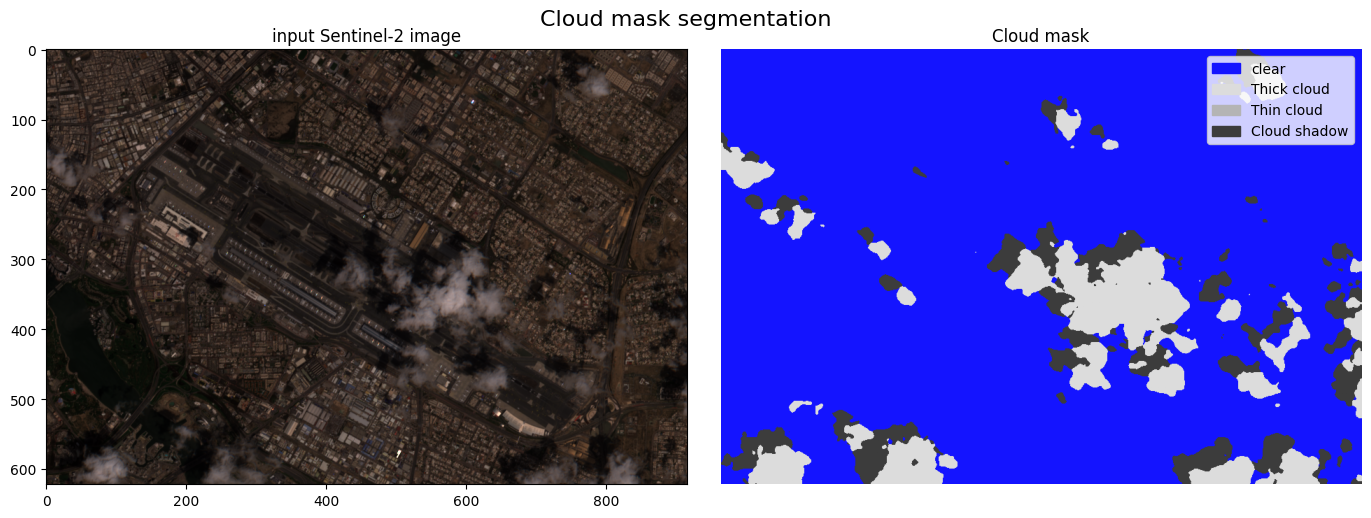

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels.squeeze(), ax[1])
ax[1].set_title("Cloud mask")

vis.visualize_hsi(hsi, ax[0])
ax[0].set_title("input Sentinel-2 image")
fig.suptitle("Cloud mask segmentation", fontsize=16)

plt.show()

## XAI methods

Now, let's move to the explanations! 

Firstly, we will need to transform our segmentation problem into a regression task. The segmentation models output multi-dimensional arrays, which cannot be analysed easily by standard XAI methods. Fortunately, using a simple trick, we can aggregate all the outputs. The aggregation is usually performed by the region type, and in short, it comes down to simply counting pixels in each class. In the `meteors` package such simple method is implemented, but feel free to experiment with different aggregation functions on your own.

To illustrate the behaviour of such aggregation function, we will use it in our settings. Let's import the generator function, and initialize it, with correct parameters

In [36]:
from meteors.utils import agg_segmentation_postprocessing

postprocessing = agg_segmentation_postprocessing(
    soft_labels=True,  # the model outputs probability of each class
    classes_numb=len(cloudsen12_segment_interpretation),  # our model outputs 4 classes
    class_axis=1,
)

The function generator `agg_segmentation_postprocessing` takes as an input few parameters of the model. More details about this function can be found in the documentation.

Let us discuss the parameters of this function:
- `soft_labels` parameter specifies whether the analysed model outputs soft labels (probabilities of pixels belonging to each class) or hard labels (one class is assigned for each pixel). In case the model uses hard labels, the shape of the output should be 3 dimensional, with batch size as its first dimension. The output's shape should be 4 dimensional otherwise
- `classes_numb` is a parameter specifying how many classes are predicted by the model
- `class_axis` used only for soft labels. It specifies on which axis the class dimension is. If the `class_axis` equals to 0, then batch size should be at the second dimension


Let's execute the function and investigate the aggregated output now.

In [37]:
aggregated_segmentation_mask = postprocessing(cloudmask)
aggregated_segmentation_mask  # the aggregated segmentation mask

tensor([[461402.5625,  50634.7188,      0.0000,  33250.5391]],
       grad_fn=<SumBackward1>)

In [38]:
cloudmask.shape

torch.Size([1, 4, 622, 916])

In [39]:
aggregated_segmentation_mask.shape

torch.Size([1, 4])

Text(0.5, 0, 'Class')

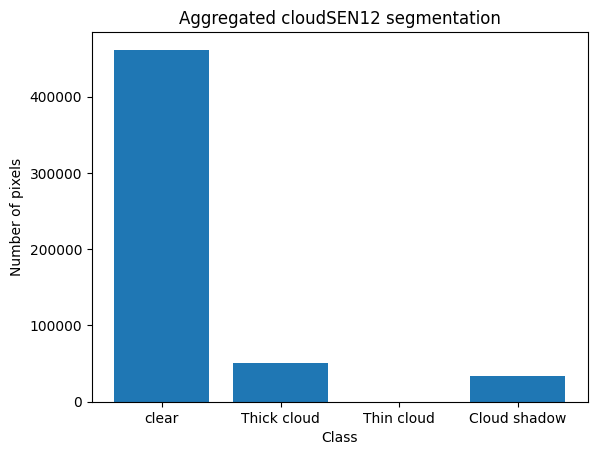

In [40]:
plt.bar(np.arange(4), aggregated_segmentation_mask.detach().squeeze())
plt.xticks(np.arange(4), cloudsen12_segment_interpretation)
plt.title("Aggregated cloudSEN12 segmentation")
plt.ylabel("Number of pixels")
plt.xlabel("Class")

As we can see, our aggregation function simply counts the pixels in each class. Now we will properly initailize the model inside the `meteors` environment. It is done by creating an object that contains all the necessary information to perform an explanation, which is:
- the forward function of the model
- the problem type, here `segmentation`

In [41]:
explainable_model = mt.models.ExplainableModel(model.predict, problem_type="segmentation")

we can perform inference as before, but now our explanation methods will better know how to handle such model:

In [42]:
cloudmask = explainable_model(hsi.image.unsqueeze(0))

Now, having everything properly initalized, we are ready to create explanations!

### LIME explanations

Firtly, we will use the [LIME](https://dl.acm.org/doi/abs/10.1145/2939672.2939778) method to explain the model's behaviour. In this notebook, we will assume that you already know the basics of LIME, so we won't describe all the details of the performed analysis. More detailed description of LIME method and its implentation in the `meteors` package can be found [in the vignette on LIME](https://xai4space.github.io/meteors/latest/tutorials/lime/).

To initialize the LIME explainer, we need to pass the explainable model, the postprocessing function that was created a while ago and additionally an interpretable model, that will approximate the explained model's behaviour.

In [43]:
interpretable_model = mt.models.SkLearnLasso(alpha=0.001)

lime = mt.attr.Lime(
    explainable_model=explainable_model,
    interpretable_model=interpretable_model,
    postprocessing_segmentation_output=postprocessing,
)

Our LIME implementation enables to analyze remote sensing imagery based on one of the dimensions - spatial or spectral. 

#### Spatial analysis

Firstly, let us verify, which image regions contribute the most to the specific class predictions - we will perform spatial analysis of the model. LIME explanation method requires the input feature space to be low-dimensional and to satisfy this condition, we will create a LIME segmentation mask, which will help understanding LIME which regions are more relevant for the cloudsen model. Please note here, that the segmentation mask created for the LIME method is something completely different from the output created by the cloudsen model.

Now, we will create the LIME segmentation mask, and later create attributions for the class 0 - the clear sky.

In [44]:
lime_seg_mask = lime.get_segmentation_mask(hsi, segmentation_method="slic", num_interpret_features=50)

attributes = lime.get_spatial_attributes(hsi, target=0, segmentation_mask=lime_seg_mask)

2024-11-13 13:35:18.707 | WARNING  | meteors.attr.explainer:device:179 - Not a torch model, setting device to cpu


Score of the attribution: 1.0


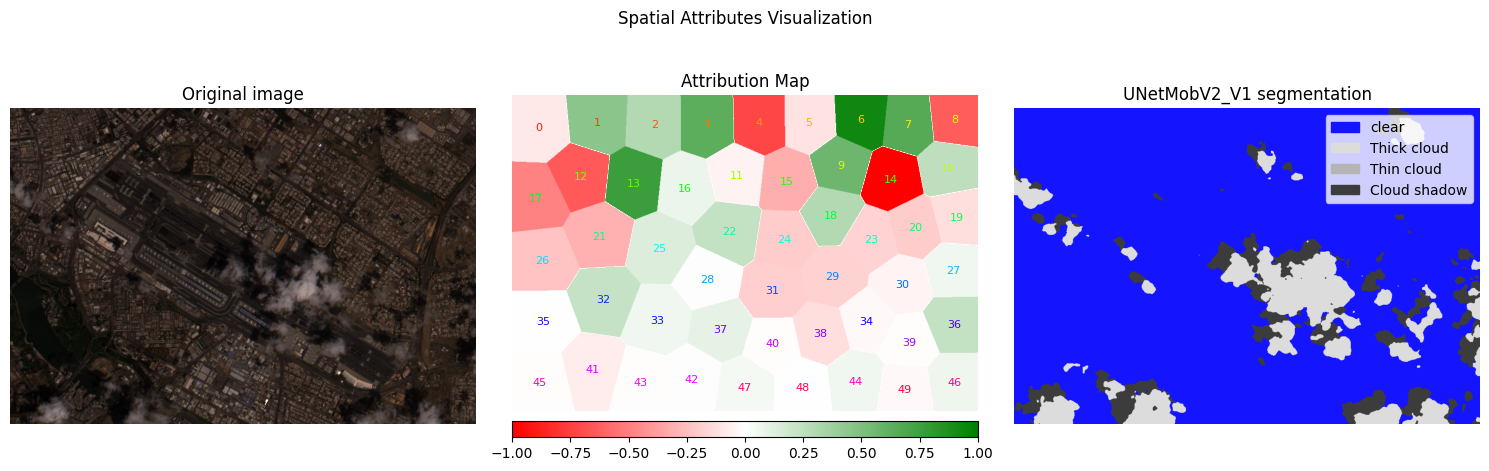

In [45]:
fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
ax[2].clear()
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels, ax=ax[2])
ax[2].set_title("UNetMobV2_V1 segmentation")
print(f"Score of the attribution: {attributes.score}")
fig.tight_layout()
plt.show()

The figure above is a slight modification of the baseline figure provided by the `meteors` pacakge, which summarizes the spatial analysis for a specific image. 

The colors in the attribution map, show in the center, have the following meaning:
- **Red**: This superpixel is negatively correlated with the input. In our case, it means that the presence of this superpixel contributed to lowering the value for the target class `0`.
- **White**: This segment did not have a significant impact on the output.
- **Green**: This superpixel is positively correlated with the output. Its presence increases the value for the class `0`.


As we can see in the figure above, the most relevant regions are in the top of the input image.

Score of the attribution: 1.0


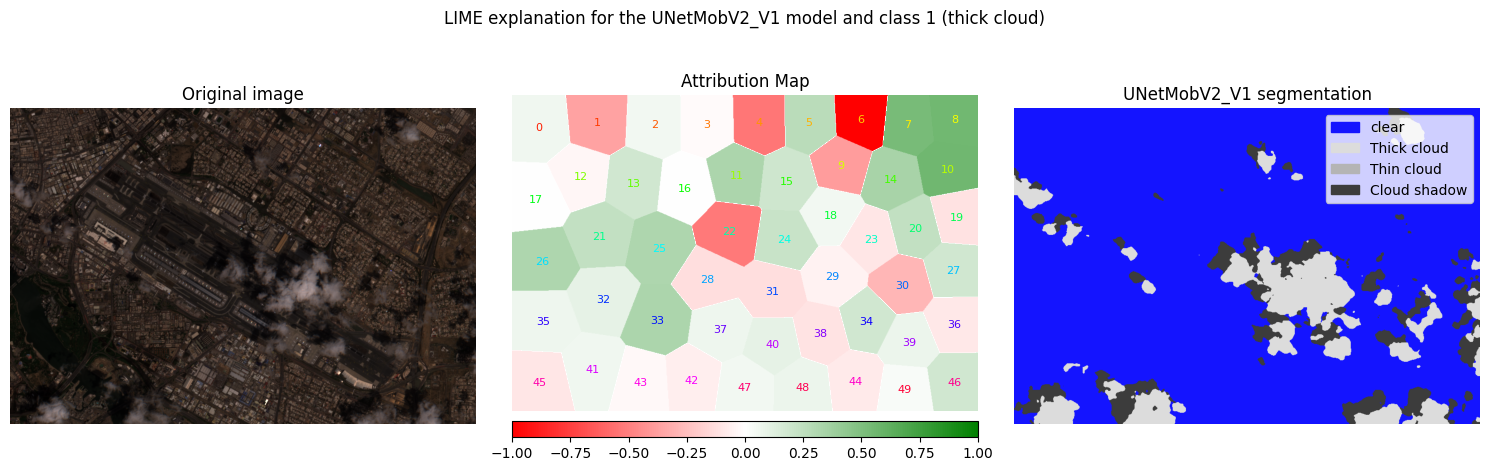

In [46]:
attributes = lime.get_spatial_attributes(hsi, target=1, segmentation_mask=lime_seg_mask, num_samples=100)

fig, ax = mt.visualize.visualize_spatial_attributes(attributes, use_pyplot=False)
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 1 (thick cloud)")
ax[2].clear()
cloudsen12.plot_cloudSEN12mask(cloudmask_hard_labels, ax=ax[2])
ax[2].set_title("UNetMobV2_V1 segmentation")
print(f"Score of the attribution: {attributes.score}")
fig.tight_layout()
plt.show()

For the thick cloud segmentation, the situation is very similar. Again the regions from the top of the image seems to be the most relevant to the cloudsen model

### Spectral analysis

Now, we will perform spectral analysis, which focuses on different bands and their impact on the models predictions. For the multispectral images, we can analyse the impact of all the bands seperately, or group them into superbands. Firstly, let's investigate, which of the bands are the most important.

To do so, we will need to create a band mask - a similar object to the lime segmentation mask, but with aggregations in the spectral dimension.

In [47]:
band_indices = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B08": 7,
    "B8A": 8,
    "B09": 9,
    "B10": 10,
    "B11": 11,
    "B12": 12,
}

band_mask, band_names = lime.get_band_mask(hsi, band_indices=band_indices)

attributes = lime.get_spectral_attributes(hsi, target=0, band_mask=band_mask, band_names=band_names)

C:\Users\tymot\Documents\praca\pineapple\meteors2\src\meteors\attr\lime_base.py:712: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")


once the attributions are calculated, we can easily visualize them:

Score of the attribution: 1.0


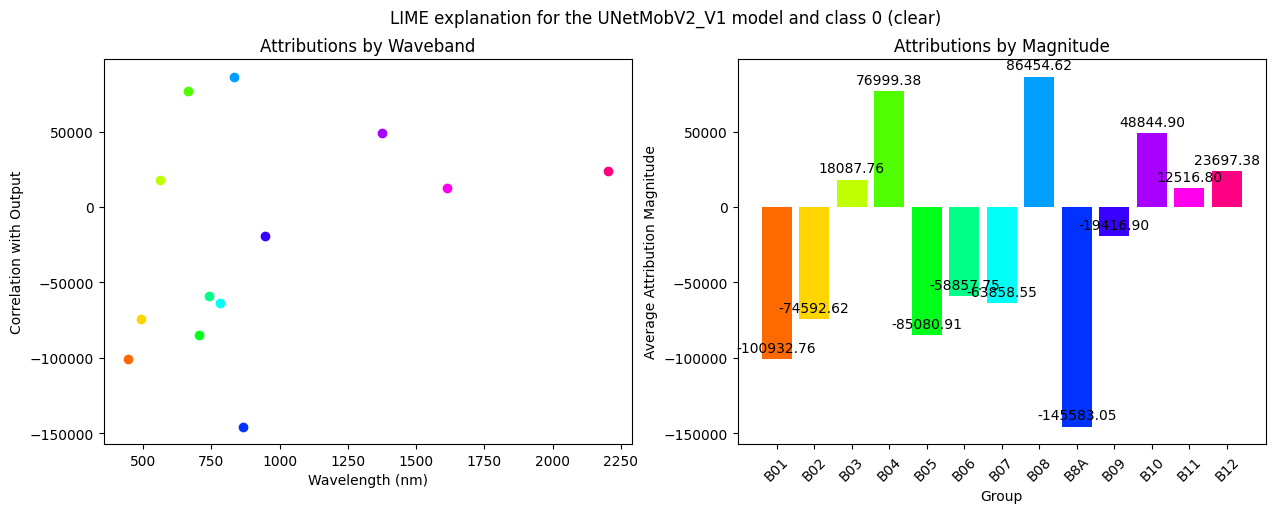

In [48]:
mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 0 (clear)")
plt.show()

In the chart above, we can see which of the specified bands contribute the most to the model's prediction. On the left, we can exactly see the correlation with the output and the bands wavelenghts, whereas plot on the right allows to easily compare the attribution values. 

As we can see, the most important bands for segmentatating the clear sky regions are bands number 4 and 6. In fact, the bands B11, B08 and B04 are used usually to segment the clouds using the standard non=machine learning approach. 

Similarily, as in the case of the spatial explanations, we can also analyse easily different classes, by passing a different target value to the function.

In [ ]:
attributes = lime.get_spectral_attributes(
    hsi,
    target=1,  # thick cloud
    band_mask=band_mask,
    band_names=band_names,
    n_samples=200,
    perturbations_per_eval=20,
)

mt.visualize.visualize_spectral_attributes(attributes)
print(f"Score of the attribution: {attributes.score}")
fig = plt.gcf()
fig.suptitle("LIME explanation for the UNetMobV2_V1 model and class 1 (thick cloud)")
plt.show()

C:\Users\tymot\Documents\praca\pineapple\meteors2\src\meteors\attr\lime_base.py:712: UserWarning: Minimum element in feature mask is not 0, shifting indices to start at 0.
  warnings.warn("Minimum element in feature mask is not 0, shifting indices to" " start at 0.")


### Attribution methods

We will use an example of Integrated Gradients method. More about the method itself can be found in the [original paper](https://doi.org/10.48550/arXiv.1703.01365). The usage of this, and different attribution methods can be also found in the [vignette on attribution methods](https://xai4space.github.io/meteors/latest/tutorials/attribution_methods/) from the meteors package.

In [ ]:
ig = mt.attr.InputXGradient(explainable_model=explainable_model, postprocessing_segmentation_output=postprocessing)

attributes = ig.attribute(hsi, target=0)

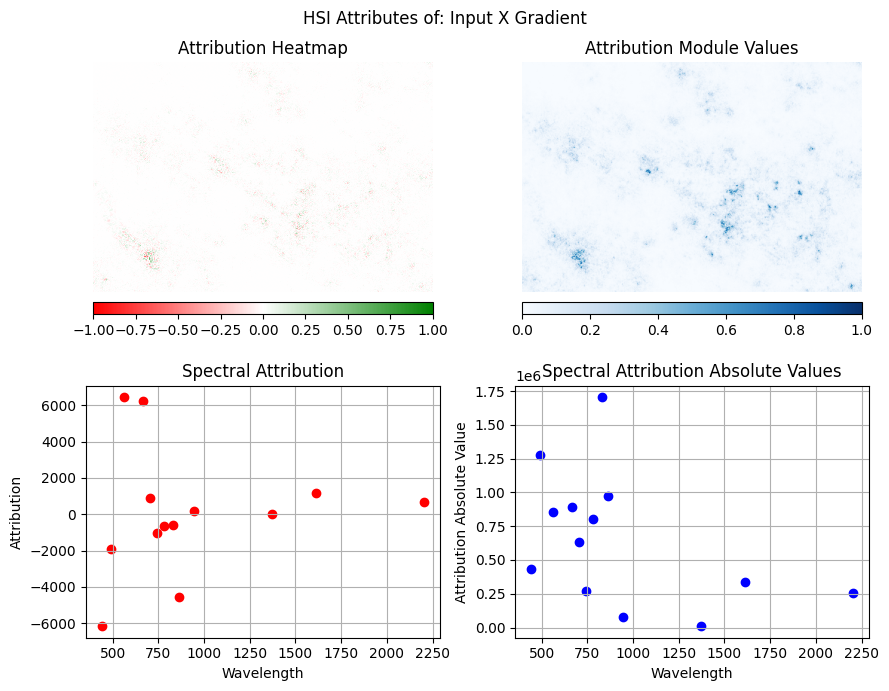

In [ ]:
fig, ax = vis.visualize_attributes(attributes)